In [1]:

###############################
##### importing libraries #####
###############################

import os
import random
from tqdm import tqdm
import numpy as np, numpy.random
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset  
from torchvision.transforms import Compose
torch.backends.cudnn.benchmark=True
import copy

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
##### Hyperparameters for federated learning #########
num_clients = 10
num_selected = 6
num_rounds = 150
epochs = 5
batch_size = 32

classes_pc = 5

In [3]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return (tensor + torch.randn(tensor.size()) * self.std + self.mean)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [4]:
np.random.dirichlet(np.ones(num_clients), size=1)[0]

array([0.14621847, 0.19144507, 0.08063636, 0.02670773, 0.0734351 ,
       0.02733149, 0.18999231, 0.20267645, 0.0586    , 0.00295702])

In [5]:
def get_cifar10():
  '''Return CIFAR10 train/test data and labels as numpy arrays'''
  data_train = torchvision.datasets.CIFAR10('./data', train=True, download=True)
  data_test = torchvision.datasets.CIFAR10('./data', train=False, download=True) 
  
  x_train, y_train = data_train.data.transpose((0,3,1,2)), np.array(data_train.targets)
  x_test, y_test = data_test.data.transpose((0,3,1,2)), np.array(data_test.targets)
  
  return x_train, y_train, x_test, y_test

def print_image_data_stats(data_train, labels_train, data_test, labels_test):
  print("\nData: ")
  print(" - Train Set: ({},{}), Range: [{:.3f}, {:.3f}], Labels: {},..,{}".format(
    data_train.shape, labels_train.shape, np.min(data_train), np.max(data_train),
      np.min(labels_train), np.max(labels_train)))
  print(" - Test Set: ({},{}), Range: [{:.3f}, {:.3f}], Labels: {},..,{}".format(
    data_test.shape, labels_test.shape, np.min(data_train), np.max(data_train),
      np.min(labels_test), np.max(labels_test)))

In [6]:

def clients_rand(train_len, nclients):
  '''
  train_len: size of the train data
  nclients: number of clients
  
  Returns: to_ret
  
  This function creates a random distribution 
  for the clients, i.e. number of images each client 
  possess.
  '''
  client_tmp=[]
  sum_=0
  #### creating random values for each client ####
  for i in range(nclients-1):
    tmp=random.randint(10,100)
    sum_+=tmp
    client_tmp.append(tmp)
  sum_+=random.randint(10,100)
  client_tmp= np.array(client_tmp)
  #### using those random values as weights ####
  clients_dist= ((client_tmp/sum_)*train_len).astype(int)
  num  = train_len - clients_dist.sum()
  to_ret = list(clients_dist)
  to_ret.append(num)
  return to_ret

https://towardsdatascience.com/preserving-data-privacy-in-deep-learning-part-2-6c2e9494398b

In [7]:

def split_image_data_realwd(data, labels, n_clients=100, verbose=True):
  '''
  Splits (data, labels) among 'n_clients s.t. every client can holds any number of classes which is trying to simulate real world dataset
  Input:
    data : [n_data x shape]
    labels : [n_data (x 1)] from 0 to n_labels(10)
    n_clients : number of clients
    verbose : True/False => True for printing some info, False otherwise
  Output:
    clients_split : splitted client data into desired format
  '''
  def break_into(n,m):
    ''' 
    return m random integers with sum equal to n 
    '''
    to_ret = [1 for i in range(m)]
    for i in range(n-m):
        ind = random.randint(0,m-1)
        to_ret[ind] += 1
    return to_ret

  #### constants ####
  n_classes = len(set(labels))
  classes = list(range(n_classes))
  np.random.shuffle(classes)
  label_indcs  = [list(np.where(labels==class_)[0]) for class_ in classes]
  
  #### classes for each client ####
  tmp = [np.random.randint(1,10) for i in range(n_clients)]
  total_partition = sum(tmp)

  #### create partition among classes to fulfill criteria for clients ####
  class_partition = break_into(total_partition, len(classes))

  #### applying greedy approach first come and first serve ####
  class_partition = sorted(class_partition,reverse=True)
  class_partition_split = {}

  #### based on class partition, partitioning the label indexes ###
  for ind, class_ in enumerate(classes):
      class_partition_split[class_] = [list(i) for i in np.array_split(label_indcs[ind],class_partition[ind])]
      
#   print([len(class_partition_split[key]) for key in  class_partition_split.keys()])

  clients_split = []
  count = 0
  for i in range(n_clients):
    n = tmp[i]
    j = 0
    indcs = []

    while n>0:
        class_ = classes[j]
        if len(class_partition_split[class_])>0:
            indcs.extend(class_partition_split[class_][-1])
            count+=len(class_partition_split[class_][-1])
            class_partition_split[class_].pop()
            n-=1
        j+=1

    ##### sorting classes based on the number of examples it has #####
    classes = sorted(classes,key=lambda x:len(class_partition_split[x]),reverse=True)
    if n>0:
        raise ValueError(" Unable to fulfill the criteria ")
    clients_split.append([data[indcs], labels[indcs]])
#   print(class_partition_split)
#   print("total example ",count)


  def print_split(clients_split): 
    print("Data split:")
    for i, client in enumerate(clients_split):
      split = np.sum(client[1].reshape(1,-1)==np.arange(n_labels).reshape(-1,1), axis=1)
      print(" - Client {}: {}".format(i,split))
    print()
      
    if verbose:
      print_split(clients_split)
  
  clients_split = np.array(clients_split)
  
  return clients_split

### Data Processing

In [8]:
from PIL import Image
import numpy as np
import torchvision.transforms.functional as T

def load_image(infilename, resize=32) :
    img = T.resize(Image.open(infilename), size=resize)
    img.load()
    data = np.asarray(img, dtype="uint8")
    return np.transpose(data)

In [9]:
import glob, random
images = glob.glob("./noisy_data/small_scale/dead_leaves-mixed/train/0000000000/*.jpg")

In [10]:
natural_images = np.asarray(list(map(load_image, images)))

In [11]:
natural_images[0].shape

(3, 32, 32)

In [12]:
def mixup_data(x, data, alpha=1.0, use_cuda=True):

    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    # if alpha > 0.:
    #     lam = np.random.beta(alpha, alpha)
    # else:
    #     lam = 1.
    # batch_size = x.size()[0]
    # if use_cuda:
    #     index = torch.randperm(batch_size).cuda()
    # else:
    #     index = torch.randperm(batch_size)
    low = 0.1
    k = 3

    dist = np.random.beta(alpha, alpha)
    main_weight = .5 + (dist * .25)
    a = np.random.rand(k)
    a = (a/a.sum()*(1-low*k))
    weights = a+low
    weights = weights * (1-main_weight)
    mixed_x = ((x * main_weight) + np.sum([arr * weights[i] for i, arr in enumerate(np.random.choice(data, k))], axis=0)).astype(np.uint8)
    # y_a, y_b = y, y[index]
    return mixed_x

In [13]:
np.random.beta(1,1)

0.66090360551415

In [14]:
low = 0.1
k = 3

a = np.random.rand(k)
a = (a/a.sum()*(1-low*k))
weights = a+low
weights = weights / 2

In [15]:
arr1 = np.zeros((3, 3))
arr2 = np.ones((3, 3))
arr3 = np.ones((3, 3))
np.sum([arr * weights[i] for i, arr in enumerate([arr1,arr2,arr3])], axis=0)

array([[0.27834948, 0.27834948, 0.27834948],
       [0.27834948, 0.27834948, 0.27834948],
       [0.27834948, 0.27834948, 0.27834948]])

In [16]:
def AddNoise(tensor, mean, std, gaussian_application, natural_image_application):
    choice = np.random.rand()
    if choice < gaussian_application:
        tensor = torch.from_numpy(tensor)
        return ((tensor + torch.randn(tensor.size()) * std + mean).numpy()).astype(np.uint8)
    elif choice < (gaussian_application + natural_image_application):
        return natural_images[np.random.randint(1000)]
    else:
        return tensor

In [17]:

def split_image_data(data, labels, n_clients=100, classes_per_client=10, shuffle=True, verbose=True):
  '''
  Splits (data, labels) among 'n_clients s.t. every client can holds 'classes_per_client' number of classes
  Input:
    data : [n_data x shape]
    labels : [n_data (x 1)] from 0 to n_labels
    n_clients : number of clients
    classes_per_client : number of classes per client
    shuffle : True/False => True for shuffling the dataset, False otherwise
    verbose : True/False => True for printing some info, False otherwise
  Output:
    clients_split : client data into desired format
  '''
  #### constants ####
  n_data = data.shape[0]
  n_labels = np.max(labels) + 1
  # gauss = lambda x, y, z : x + torch.randn(x.size()) * z + y
  noise_data = AddNoise(data, 0., 50., .0, .0)

  ### client distribution ####
  data_per_client = clients_rand(len(data), n_clients)
  data_per_client_per_class = [np.maximum(1,nd // classes_per_client) for nd in data_per_client]

  # sort for labels
  data_idcs = [[] for i in range(n_labels)]
  for j, label in enumerate(labels):
    data_idcs[label] += [j]
  if shuffle:
    for idcs in data_idcs:
      np.random.shuffle(idcs)

  noise_idcs = copy.deepcopy(data_idcs)
  # split data among clients
  clients_split = []
  c = 0
  # We want all clients to have this much data for each class
  max_data = np.max(data_per_client_per_class)
  print(f"Data Per Client: {data_per_client_per_class}, and goal amount of data each client has per class: {max_data}")
  for i in range(n_clients):
    client_idcs = []
    share_idcs = []

    budget = data_per_client[i]
    c = np.random.randint(n_labels)
    cl = []
    while budget > 0:
      take = min(data_per_client_per_class[i], len(data_idcs[c]), budget)

      client_idcs += data_idcs[c][:take]
      data_idcs[c] = data_idcs[c][take:]

      budget -= take
      cl.append(c)
      if take < max_data:
        fill = min((max_data-take), len(noise_idcs[c]))
        share_idcs += random.choices(noise_idcs[c], k=fill)
      c = (c + 1) % n_labels

    # add noise examples
    class_list = [x for x in range (0, n_labels)]
    noise_classes = [x for x in class_list if x not in cl]
    for class_ in noise_classes:
      take = min(max_data, len(noise_idcs[class_]))
      share_idcs += random.choices(noise_idcs[class_], k=take)

    print(f"Untouched: {len(client_idcs)} Noise: {len(share_idcs)}, Classes: {cl}")
    print(f"Labels: {np.asarray(np.unique(labels[(client_idcs + share_idcs)], return_counts=True)).T}")
    clients_split += [(np.concatenate((data[client_idcs], noise_data[share_idcs])), labels[(client_idcs + share_idcs)])]

  def print_split(clients_split):
    print("Data split:")
    for i, client in enumerate(clients_split):
      split = np.sum(client[1].reshape(1,-1)==np.arange(n_labels).reshape(-1,1), axis=1)
      print(" - Client {}: {}".format(i,split))
    print()

    if verbose:
      print_split(clients_split)

  clients_split = np.array(clients_split)

  return clients_split

### Helpers

In [18]:

def shuffle_list(data):
  '''
  This function returns the shuffled data
  '''
  for i in range(len(data)):
    tmp_len= len(data[i][0])
    index = [i for i in range(tmp_len)]
    random.shuffle(index)
    data[i][0],data[i][1] = shuffle_list_data(data[i][0],data[i][1])
  return data


def shuffle_list_data(x, y):
  '''
  This function is a helper function, shuffles an
  array while maintaining the mapping between x and y
  '''
  inds = list(range(len(x)))
  random.shuffle(inds)

In [19]:

class CustomImageDataset(Dataset):
  '''
  A custom Dataset class for images
  inputs : numpy array [n_data x shape]
  labels : numpy array [n_data (x 1)]
  '''
  def __init__(self, inputs, labels, transforms=None):
      assert inputs.shape[0] == labels.shape[0]
      self.inputs = torch.Tensor(inputs)
      self.labels = torch.Tensor(labels).long()
      self.transforms = transforms 

  def __getitem__(self, index):
      img, label = self.inputs[index], self.labels[index]

      if self.transforms is not None:
        img = self.transforms(img)

      return (img, label)

  def __len__(self):
      return self.inputs.shape[0]
          

def get_default_data_transforms(train=True, verbose=True):
  transforms_train = {
  'cifar10' : transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]),#(0.24703223, 0.24348513, 0.26158784)
  }
  transforms_eval = {    
  'cifar10' : transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
  }
  if verbose:
    print("\nData preprocessing: ")
    for transformation in transforms_train['cifar10'].transforms:
      print(' -', transformation)
    print()

  return (transforms_train['cifar10'], transforms_eval['cifar10'])

In [20]:

def get_data_loaders(nclients,batch_size,classes_pc=10, real_wd =False ,verbose=True ):
  
  x_train, y_train, x_test, y_test = get_cifar10()

  if verbose:
    print_image_data_stats(x_train, y_train, x_test, y_test)

  transforms_train, transforms_eval = get_default_data_transforms(verbose=False)
  
  if real_wd:
    split = split_image_data_realwd(x_train, y_train, n_clients=nclients, verbose = verbose)
  else:  
    split = split_image_data(x_train[:10000], y_train[:10000], n_clients=nclients, classes_per_client=classes_pc, verbose=verbose)
  
  split_tmp = split #shuffle_list(split)
  
  client_loaders = [torch.utils.data.DataLoader(CustomImageDataset(x, y, transforms_train), batch_size=batch_size, shuffle=True, drop_last=True) for x, y in split_tmp]
  
  test_loader  = torch.utils.data.DataLoader(CustomImageDataset(x_test, y_test, transforms_eval), batch_size=100, shuffle=False)

  return client_loaders, test_loader

In [21]:
x_train, y_train, x_test, y_test = get_cifar10()
type(x_train)

Files already downloaded and verified
Files already downloaded and verified


numpy.ndarray

In [22]:
#(GaussianNoise(x_train, 0., 50., 1).astype(np.uint8) == x_train).all()

In [23]:
arr = AddNoise(x_train, 0., 3., 1, 0)

In [24]:
# from PIL import Image as im
# arr = np.ascontiguousarray(arr[0].transpose(1,2,0))
# data = im.fromarray(arr, 'RGB')
# data.save('gaussian3.png')

In [25]:
# x_train.shape

In [26]:
# GaussianNoise(x_train, 0., 3.).astype(np.uint8)

In [27]:

# #############################################################
# ##### Creating desired data distribution among clients  #####
# #############################################################

# # Image augmentation 
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#     transforms.RandomApply([AddGaussianNoise(0., 3.)], p=.8)
# ])

# # Loading CIFAR10 using torchvision.datasets
# traindata = datasets.CIFAR10('./data', train=True, download=True,
#                        transform= transform_train)
# train_fake_data = datasets.CIFAR10('./data', train=True, download=True
#                     )

# # Dividing the training data into num_clients, with each client having equal number of images
# traindata_split = torch.utils.data.random_split(traindata, np.random.dirichlet(np.ones(num_clients), size=1)[0])

# # Creating a pytorch loader for a Deep Learning model
# train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

# # Normalizing the test images
# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

# # Loading the test iamges and thus converting them into a test_loader
# test_loader = torch.utils.data.DataLoader(
#         datasets.CIFAR10('./data', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
#         ), batch_size=batch_size, shuffle=True)

### Loading

In [28]:
train_loader, test_loader = get_data_loaders(num_clients, batch_size, classes_pc=2, real_wd=False, verbose=True)

Files already downloaded and verified
Files already downloaded and verified

Data: 
 - Train Set: ((50000, 3, 32, 32),(50000,)), Range: [0.000, 255.000], Labels: 0,..,9
 - Test Set: ((10000, 3, 32, 32),(10000,)), Range: [0.000, 255.000], Labels: 0,..,9
Data Per Client: [481, 376, 167, 240, 690, 648, 512, 554, 1035, 294], and goal amount of data each client has per class: 1035
Untouched: 962 Noise: 9060, Classes: [2, 3]
Labels: [[   0 1005]
 [   1  974]
 [   2 1035]
 [   3 1035]
 [   4  999]
 [   5  937]
 [   6 1030]
 [   7 1001]
 [   8 1025]
 [   9  981]]
Untouched: 753 Noise: 9351, Classes: [5, 6, 7]
Labels: [[   0 1005]
 [   1  974]
 [   2 1032]
 [   3 1016]
 [   4  999]
 [   5 1035]
 [   6 1035]
 [   7 1002]
 [   8 1025]
 [   9  981]]
Untouched: 334 Noise: 9730, Classes: [8, 9]
Labels: [[   0 1005]
 [   1  974]
 [   2 1032]
 [   3 1016]
 [   4  999]
 [   5  937]
 [   6 1030]
 [   7 1001]
 [   8 1035]
 [   9 1035]]
Untouched: 481 Noise: 9575, Classes: [3, 4, 5]
Labels: [[   0 1005]
 

/tmp/ipykernel_34789/1086344958.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clients_split = np.array(clients_split)


In [29]:
# images, labels = next(iter(train_loader[0]))

In [30]:
# images[0]

In [31]:

#################################
##### Neural Network model #####
#################################

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        output = F.log_softmax(out, dim=1)
        return output

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [32]:
def client_update(client_model, optimizer, train_loader, epoch=5):
    """
    This function updates/trains client model on client data
    """
    model.train()
    for e in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = client_model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
    return loss.item()

In [33]:

def server_aggregate(global_model, client_models):
    """
    This function has aggregation method 'mean'
    """
    ### This will take simple mean of the weights of models ###
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

In [34]:

def test(global_model, test_loader):
    """This function test the global model on test data and returns test loss and test accuracy """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = global_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    return test_loss, acc

In [35]:
from torchvision.models import resnet

In [36]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from argparse import ArgumentParser
from torchvision import transforms as tt

In [37]:
class ClientUpdate(object):
    def __init__(self, dataset, batchSize, learning_rate, epochs, sch_flag):
        self.train_loader = dataset
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.sch_flag = sch_flag

    def train(self, model):

        criterion = nn.CrossEntropyLoss()
        # optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.95, weight_decay = 5e-4)
        optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)
        # if self.sch_flag == True:
        #    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5)
        # my_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)
        e_loss = []
        for epoch in range(1, self.epochs + 1):

            train_loss = 0.0

            model.train()
            for data, labels in self.train_loader:
                if data.size()[0] < 2:
                    continue;

                if torch.cuda.is_available():
                    data, labels = data.cuda(), labels.cuda()

                # clear the gradients
                optimizer.zero_grad()
                # make a forward pass
                output = model(data)
                # calculate the loss
                loss = criterion(output, labels)
                # do a backwards pass
                loss.backward()
                # perform a single optimization step
                optimizer.step()
                # update training loss
                train_loss += loss.item() * data.size(0)
                # if self.sch_flag == True:
                #  scheduler.step(train_loss)
            # average losses
            train_loss = train_loss / len(self.train_loader.dataset)
            e_loss.append(train_loss)

            # self.learning_rate = optimizer.param_groups[0]['lr']

        total_loss = sum(e_loss) / len(e_loss)

        return model.state_dict(), total_loss

In [38]:
def testing(model, dataset, bs, criterion, num_classes, classes):
    # test loss
    test_loss = 0.0
    correct_class = list(0. for i in range(num_classes))
    total_class = list(0. for i in range(num_classes))

    test_loader = DataLoader(dataset, batch_size=bs)
    l = len(test_loader)
    model.eval()
    for data, labels in test_loader:

        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        output = model(data)
        loss = criterion(output, labels)
        test_loss += loss.item() * data.size(0)

        _, pred = torch.max(output, 1)

        correct_tensor = pred.eq(labels.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(
            correct_tensor.cpu().numpy())

        # test accuracy for each object class
        for i in range(num_classes):
            label = labels.data[i]
            correct_class[label] += correct[i].item()
            total_class[label] += 1

    # avg test loss
    test_loss = test_loss / len(test_loader.dataset)

    return 100. * np.sum(correct_class) / np.sum(total_class), test_loss

In [39]:
def training(model, rounds, batch_size, lr, ds, C, K, E, plt_title, plt_color, cifar_data_test,
             test_batch_size, criterion, num_classes, classes_test, sch_flag):
    """
    Function implements the Federated Averaging Algorithm from the FedAvg paper.
    Specifically, this function is used for the server side training and weight update

    Params:
      - model:           PyTorch model to train
      - rounds:          Number of communication rounds for the client update
      - batch_size:      Batch size for client update training
      - lr:              Learning rate used for client update training
      - ds:              Dataset used for training
      - data_dict:       Type of data partition used for training (IID or non-IID)
      - C:               Fraction of clients randomly chosen to perform computation on each round
      - K:               Total number of clients
      - E:               Number of training passes each client makes over its local dataset per round
      - tb_writer_name:  Directory name to save the tensorboard logs
    Returns:
      - model:           Trained model on the server
    """

    # global model weights
    global_weights = model.state_dict()

    # training loss
    train_loss = []
    test_loss = []
    test_accuracy = []
    best_accuracy = 0
    # measure time
    start = time.time()

    for curr_round in range(1, rounds + 1):
        w, local_loss = [], []
        # Retrieve the number of clients participating in the current training
        m = max(int(C * K), 1)
        # Sample a subset of K clients according with the value defined before
        S_t = np.random.choice(range(K), m, replace=False)
        # For the selected clients start a local training
        for k in S_t:
            # Compute a local update
            local_update = ClientUpdate(dataset=ds[k], batchSize=batch_size, learning_rate=lr, epochs=E,
                                        sch_flag=sch_flag)
            # Update means retrieve the values of the network weights
            weights, loss = local_update.train(model=copy.deepcopy(model))

            w.append(copy.deepcopy(weights))
            local_loss.append(copy.deepcopy(loss))
        # lr = 0.999*lr
        # updating the global weights
        weights_avg = copy.deepcopy(w[0])
        for k in weights_avg.keys():
            for i in range(1, len(w)):
                weights_avg[k] += w[i][k]

            weights_avg[k] = torch.div(weights_avg[k], len(w))

        global_weights = weights_avg

        if curr_round == 200:
            lr = lr / 2
            E = E - 1

        if curr_round == 300:
            lr = lr / 2
            E = E - 2

        if curr_round == 400:
            lr = lr / 5
            E = E - 3

        # move the updated weights to our model state dict
        model.load_state_dict(global_weights)

        # loss
        loss_avg = sum(local_loss) / len(local_loss)
        # print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)), lr)
        train_loss.append(loss_avg)

        t_accuracy, t_loss = testing(model, cifar_data_test, test_batch_size, criterion, num_classes, classes_test)
        test_accuracy.append(t_accuracy)
        test_loss.append(t_loss)

        if best_accuracy < t_accuracy:
            best_accuracy = t_accuracy
        # torch.save(model.state_dict(), plt_title)
        print(curr_round, loss_avg, t_loss, test_accuracy[0], best_accuracy)
        # print('best_accuracy:', best_accuracy, '---Round:', curr_round, '---lr', lr, '----localEpocs--', E)

    end = time.time()
    plt.rcParams.update({'font.size': 8})
    fig, ax = plt.subplots()
    x_axis = np.arange(1, rounds + 1)
    y_axis1 = np.array(train_loss)
    y_axis2 = np.array(test_accuracy)
    y_axis3 = np.array(test_loss)

    ax.plot(x_axis, y_axis1, 'tab:' + 'green', label='train_loss')
    ax.plot(x_axis, y_axis2, 'tab:' + 'blue', label='test_accuracy')
    ax.plot(x_axis, y_axis3, 'tab:' + 'red', label='test_loss')
    ax.legend(loc='upper left')
    ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
           title=plt_title)
    ax.grid()
    # fig.savefig(plt_title+'.jpg', format='jpg')
    print("Training Done!")
    print("Total time taken to Train: {}".format(end - start))

    return model

In [40]:
class MyGroupNorm(nn.Module):
    def __init__(self, num_channels):
        super(MyGroupNorm, self).__init__()
        self.norm = nn.GroupNorm(num_groups=2, num_channels=num_channels,
                                 eps=1e-5, affine=True)

    def forward(self, x):
        x = self.norm(x)
        return x

In [41]:
# parser = ArgumentParser()
# parser.add_argument('--norm', default="bn")
# parser.add_argument('--partition', default="noniid")
# parser.add_argument('--client_number', default=100)
# parser.add_argument('--alpha_partition', default=0.5)
# parser.add_argument('--commrounds', type=int, default=100)
# parser.add_argument('--clientfr', type=float, default=0.1)
# parser.add_argument('--numclient', type=int, default=100)
# parser.add_argument('--clientepochs', type=int, default=20)
# parser.add_argument('--clientbs', type=int, default=64)
# parser.add_argument('--clientlr', type=float, default=0.001)
# parser.add_argument('--sch_flag', default=False)
# args = parser.parse_args()

norm = "bn"
partition = "noniid"
alpha_partition = 0.5
commrounds = 100
clientfr = 0.1
numclient = num_clients
clientepochs = 20
clientbs = 64
clientlr = 0.001
sch_flag = False

stats = ((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))

transforms_cifar_train = tt.Compose([tt.ToTensor(),
                                         tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                                         tt.RandomHorizontalFlip(p=0.5),
                                         tt.Normalize(*stats)])
transforms_cifar_test = transforms.Compose(
    [transforms.ToTensor(),
        transforms.Normalize(*stats)])

cifar_data_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar_train)
cifar_data_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar_test)

classes = np.array(list(cifar_data_train.class_to_idx.values()))
classes_test = np.array(list(cifar_data_test.class_to_idx.values()))
num_classes = len(classes_test)

criterion = nn.CrossEntropyLoss()

# Hyperparameters_List (H) = [rounds, client_fraction, number_of_clients, number_of_training_rounds_local, local_batch_size, lr_client]
H = [commrounds, clientfr, numclient, clientepochs, clientbs, clientlr]

# if norm == 'gn':
#     cifar_cnn = resnet.ResNet(resnet.Bottleneck, [3, 4, 6, 3], num_classes=10, zero_init_residual=False, groups=1,
#                                 width_per_group=64, replace_stride_with_dilation=None, norm_layer=MyGroupNorm)
# else:
cifar_cnn = resnet.ResNet(resnet.Bottleneck, [3, 4, 6, 3], num_classes=10, zero_init_residual=False, groups=1,
                                width_per_group=64, replace_stride_with_dilation=None)

cifar_cnn.cuda()

plot_str = partition + '_' + norm + '_' + 'comm_rounds_' + str(commrounds) + '_clientfr_' + str(
    clientfr) + '_numclients_' + str(numclient) + '_clientepochs_' + str(
    clientepochs) + '_clientbs_' + str(clientbs) + '_clientLR_' + str(clientlr)
print(plot_str)

trained_model = training(cifar_cnn, H[0], H[4], H[5], train_loader, H[1], H[2], H[3], plot_str,
                            "green", cifar_data_test, 128, criterion, num_classes, classes_test, sch_flag)

Files already downloaded and verified
Files already downloaded and verified
noniid_bn_comm_rounds_100_clientfr_0.1_numclients_10_clientepochs_20_clientbs_64_clientLR_0.001


KeyboardInterrupt: 

In [42]:
def iid_partition(dataset, clients):
    """
    I.I.D paritioning of data over clients
    Shuffle the data
    Split it between clients

    params:
      - dataset (torch.utils.Dataset): Dataset containing the Images
      - clients (int): Number of Clients to split the data between

    returns:
      - Dictionary of image indexes for each client
    """

    num_items_per_client = int(len(dataset) / clients)
    client_dict = {}
    image_idxs = [i for i in range(len(dataset))]

    for i in range(clients):
        client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
        image_idxs = list(set(image_idxs) - client_dict[i])

    return client_dict


def non_iid_partition(dataset, n_nets, alpha):
    """
        :param dataset: dataset name
        :param n_nets: number of clients
        :param alpha: beta parameter of the Dirichlet distribution
        :return: dictionary containing the indexes for each client
    """
    y_train = np.array(dataset.targets)
    min_size = 0
    K = 10
    N = y_train.shape[0]
    net_dataidx_map = {}

    while min_size < 10:
        idx_batch = [[] for _ in range(n_nets)]
        # for each class in the dataset
        for k in range(K):
            idx_k = np.where(y_train == k)[0]
            np.random.shuffle(idx_k)
            proportions = np.random.dirichlet(np.repeat(alpha, n_nets))
            ## Balance
            proportions = np.array([p * (len(idx_j) < N / n_nets) for p, idx_j in zip(proportions, idx_batch)])
            proportions = proportions / proportions.sum()
            proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
            idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, proportions))]
            min_size = min([len(idx_j) for idx_j in idx_batch])

    for j in range(n_nets):
        np.random.shuffle(idx_batch[j])
        net_dataidx_map[j] = np.array(idx_batch[j])

    # net_dataidx_map is a dictionary of length #of clients: {key: int, value: [list of indexes mapping the data among the workers}
    # traindata_cls_counts is a dictionary of length #of clients, basically assesses how the different labels are distributed among
    # the client, counting the total number of examples per class in each client.
    return net_dataidx_map

In [43]:
class CustomDataset(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label


class ClientUpdate(object):
    def __init__(self, dataset, batchSize, learning_rate, epochs, idxs, sch_flag):
        self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.sch_flag = sch_flag

    def train(self, model):

        criterion = nn.CrossEntropyLoss()
        # optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.95, weight_decay = 5e-4)
        optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)
        # if self.sch_flag == True:
        #    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5)
        # my_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)
        e_loss = []
        for epoch in range(1, self.epochs + 1):

            train_loss = 0.0

            model.train()
            for data, labels in self.train_loader:
                if data.size()[0] < 2:
                    continue;

                if torch.cuda.is_available():
                    data, labels = data.cuda(), labels.cuda()

                # clear the gradients
                optimizer.zero_grad()
                # make a forward pass
                output = model(data)
                # calculate the loss
                loss = criterion(output, labels)
                # do a backwards pass
                loss.backward()
                # perform a single optimization step
                optimizer.step()
                # update training loss
                train_loss += loss.item() * data.size(0)
                # if self.sch_flag == True:
                #  scheduler.step(train_loss)
            # average losses
            train_loss = train_loss / len(self.train_loader.dataset)
            e_loss.append(train_loss)

            # self.learning_rate = optimizer.param_groups[0]['lr']

        total_loss = sum(e_loss) / len(e_loss)

        return model.state_dict(), total_loss


"""### Server Side Training

Following Algorithm 1 from the paper
"""


def training(model, rounds, batch_size, lr, ds, data_dict, C, K, E, plt_title, plt_color, cifar_data_test,
             test_batch_size, criterion, num_classes, classes_test, sch_flag):
    """
    Function implements the Federated Averaging Algorithm from the FedAvg paper.
    Specifically, this function is used for the server side training and weight update

    Params:
      - model:           PyTorch model to train
      - rounds:          Number of communication rounds for the client update
      - batch_size:      Batch size for client update training
      - lr:              Learning rate used for client update training
      - ds:              Dataset used for training
      - data_dict:       Type of data partition used for training (IID or non-IID)
      - C:               Fraction of clients randomly chosen to perform computation on each round
      - K:               Total number of clients
      - E:               Number of training passes each client makes over its local dataset per round
      - tb_writer_name:  Directory name to save the tensorboard logs
    Returns:
      - model:           Trained model on the server
    """

    # global model weights
    global_weights = model.state_dict()

    # training loss
    train_loss = []
    test_loss = []
    test_accuracy = []
    best_accuracy = 0
    # measure time
    start = time.time()

    for curr_round in range(1, rounds + 1):
        w, local_loss = [], []
        # Retrieve the number of clients participating in the current training
        m = max(int(C * K), 1)
        # Sample a subset of K clients according with the value defined before
        S_t = np.random.choice(range(K), m, replace=False)
        # For the selected clients start a local training
        for k in S_t:
            # Compute a local update
            local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=E, idxs=data_dict[k],
                                        sch_flag=sch_flag)
            # Update means retrieve the values of the network weights
            weights, loss = local_update.train(model=copy.deepcopy(model))

            w.append(copy.deepcopy(weights))
            local_loss.append(copy.deepcopy(loss))
        # lr = 0.999*lr
        # updating the global weights
        weights_avg = copy.deepcopy(w[0])
        for k in weights_avg.keys():
            for i in range(1, len(w)):
                weights_avg[k] += w[i][k]

            weights_avg[k] = torch.div(weights_avg[k], len(w))

        global_weights = weights_avg

        if curr_round == 200:
            lr = lr / 2
            E = E - 1

        if curr_round == 300:
            lr = lr / 2
            E = E - 2

        if curr_round == 400:
            lr = lr / 5
            E = E - 3

        # move the updated weights to our model state dict
        model.load_state_dict(global_weights)

        # loss
        loss_avg = sum(local_loss) / len(local_loss)
        # print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)), lr)
        train_loss.append(loss_avg)

        t_accuracy, t_loss = testing(model, cifar_data_test, test_batch_size, criterion, num_classes, classes_test)
        test_accuracy.append(t_accuracy)
        test_loss.append(t_loss)

        if best_accuracy < t_accuracy:
            best_accuracy = t_accuracy
        # torch.save(model.state_dict(), plt_title)
        print(curr_round, loss_avg, t_loss, test_accuracy[0], best_accuracy)
        # print('best_accuracy:', best_accuracy, '---Round:', curr_round, '---lr', lr, '----localEpocs--', E)

    end = time.time()
    plt.rcParams.update({'font.size': 8})
    fig, ax = plt.subplots()
    x_axis = np.arange(1, rounds + 1)
    y_axis1 = np.array(train_loss)
    y_axis2 = np.array(test_accuracy)
    y_axis3 = np.array(test_loss)

    ax.plot(x_axis, y_axis1, 'tab:' + 'green', label='train_loss')
    ax.plot(x_axis, y_axis2, 'tab:' + 'blue', label='test_accuracy')
    ax.plot(x_axis, y_axis3, 'tab:' + 'red', label='test_loss')
    ax.legend(loc='upper left')
    ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
           title=plt_title)
    ax.grid()
    # fig.savefig(plt_title+'.jpg', format='jpg')
    print("Training Done!")
    print("Total time taken to Train: {}".format(end - start))

    return model


"""## ResNet50 Model (W & W/O GN)

> Indented block


"""


class MyGroupNorm(nn.Module):
    def __init__(self, num_channels):
        super(MyGroupNorm, self).__init__()
        self.norm = nn.GroupNorm(num_groups=2, num_channels=num_channels,
                                 eps=1e-5, affine=True)

    def forward(self, x):
        x = self.norm(x)
        return x


"""## Testing Loop"""


def testing(model, dataset, bs, criterion, num_classes, classes):
    # test loss
    test_loss = 0.0
    correct_class = list(0. for i in range(num_classes))
    total_class = list(0. for i in range(num_classes))

    test_loader = DataLoader(dataset, batch_size=bs)
    l = len(test_loader)
    model.eval()
    for data, labels in test_loader:

        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        output = model(data)
        loss = criterion(output, labels)
        test_loss += loss.item() * data.size(0)

        _, pred = torch.max(output, 1)

        correct_tensor = pred.eq(labels.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(
            correct_tensor.cpu().numpy())

        # test accuracy for each object class
        for i in range(num_classes):
            label = labels.data[i]
            correct_class[label] += correct[i].item()
            total_class[label] += 1

    # avg test loss
    test_loss = test_loss / len(test_loader.dataset)

    return 100. * np.sum(correct_class) / np.sum(total_class), test_loss

Files already downloaded and verified
Files already downloaded and verified
iid_bn_comm_rounds_100_clientfr_0.1_numclients_10_clientepochs_20_clientbs_64_clientLR_0.001
1 2.028981917095184 3.526456664276123 29.367088607594937 29.367088607594937
2 1.9885620866298677 7.217822661590576 29.367088607594937 29.367088607594937
3 1.5408104944705963 2.1895949710845946 29.367088607594937 37.34177215189873
4 1.939948887062073 2.457892044258118 29.367088607594937 37.34177215189873
5 1.9644945016384123 2.1960014999389648 29.367088607594937 37.34177215189873
6 1.697844091081619 89.16677650146484 29.367088607594937 37.34177215189873
7 1.430200507712364 2.2254912780761718 29.367088607594937 37.34177215189873
8 1.4391789371013641 3.73610962638855 29.367088607594937 38.9873417721519
9 1.1324253946542737 2.300172336387634 29.367088607594937 41.51898734177215
10 0.5529472256302833 2.80307884349823 29.367088607594937 41.51898734177215
11 0.998599880051613 2.066993391990662 29.367088607594937 41.64556962025

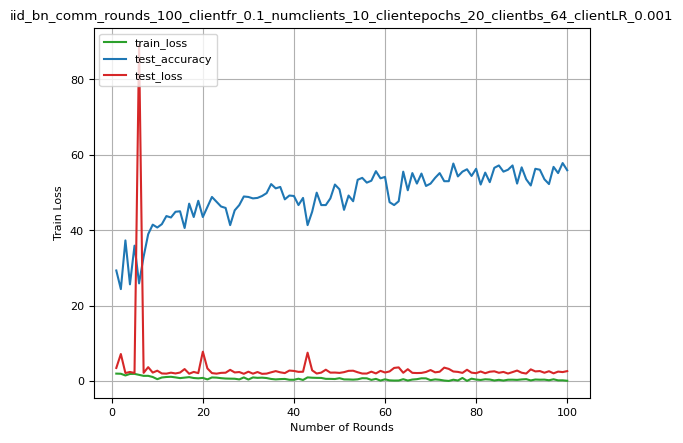

In [45]:
stats = ((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
partition = 'iid'
transforms_cifar_train = tt.Compose([tt.ToTensor(),
                                        tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                                        tt.RandomHorizontalFlip(p=0.5),
                                        tt.Normalize(*stats)])
transforms_cifar_test = transforms.Compose(
    [transforms.ToTensor(),
        transforms.Normalize(*stats)])

cifar_data_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar_train)
cifar_data_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar_test)

classes = np.array(list(cifar_data_train.class_to_idx.values()))
classes_test = np.array(list(cifar_data_test.class_to_idx.values()))
num_classes = len(classes_test)

criterion = nn.CrossEntropyLoss()

# Hyperparameters_List (H) = [rounds, client_fraction, number_of_clients, number_of_training_rounds_local, local_batch_size, lr_client]
H = [commrounds, clientfr, numclient, clientepochs, clientbs, clientlr]

if partition == 'noniid':
    # (dataset, clients, total_shards, shards_size, num_shards_per_client):
    # alpha for the Dirichlet distribution
    data_dict = non_iid_partition(cifar_data_train, 100, float(alpha_partition))
    print(len(cifar_data_train))
else:
    data_dict = iid_partition(cifar_data_train, 100)  # Uncomment for idd_partition

if norm == 'gn':
    cifar_cnn = resnet.ResNet(resnet.Bottleneck, [3, 4, 6, 3], num_classes=10, zero_init_residual=False, groups=1,
                                width_per_group=64, replace_stride_with_dilation=None, norm_layer=MyGroupNorm)
else:
    cifar_cnn = resnet.ResNet(resnet.Bottleneck, [3, 4, 6, 3], num_classes=10, zero_init_residual=False, groups=1,
                                width_per_group=64, replace_stride_with_dilation=None)

cifar_cnn.cuda()

plot_str = partition + '_' + norm + '_' + 'comm_rounds_' + str(commrounds) + '_clientfr_' + str(
    clientfr) + '_numclients_' + str(numclient) + '_clientepochs_' + str(
    clientepochs) + '_clientbs_' + str(clientbs) + '_clientLR_' + str(clientlr)
print(plot_str)

trained_model = training(cifar_cnn, H[0], H[4], H[5], cifar_data_train, data_dict, H[1], H[2], H[3], plot_str,
                            "green", cifar_data_test, 128, criterion, num_classes, classes_test, sch_flag)

In [ ]:

############################################
#### Initializing models and optimizer  ####
############################################

#### global model ##########
global_model =  resnet.ResNet(resnet.Bottleneck, [3, 4, 6, 3], num_classes=10, zero_init_residual=False, 
                             groups=1, width_per_group=64, replace_stride_with_dilation=None).cuda()

############## client models ##############
client_models = [ resnet.ResNet(resnet.Bottleneck, [3, 4, 6, 3], num_classes=10, zero_init_residual=False, groups=1, width_per_group=64, replace_stride_with_dilation=None).cuda() for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict()) ### initial synchronizing with global model 

############### optimizers ################
opt = [optim.SGD(model.parameters(), lr=0.1) for model in client_models]

In [ ]:
###### List containing info about learning #########
losses_train = []
losses_test = []
acc_train = []
acc_test = []
# Runnining FL

for r in range(num_rounds):
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]
    # client update
    loss = 0
    for i in tqdm(range(num_selected)):
        loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], epoch=epochs)
    
    losses_train.append(loss)
    # server aggregate
    server_aggregate(global_model, client_models)
    
    test_loss, acc = test(global_model, test_loader)
    losses_test.append(test_loss)
    acc_test.append(acc)
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / num_selected, test_loss, acc))


  0%|          | 0/6 [00:00<?, ?it/s]


NameError: name 'train_loader' is not defined

In [54]:
x_train, y_train, x_test, y_test = get_cifar10()
split = split_image_data(x_train, y_train, n_clients=num_clients, classes_per_client=classes_pc, verbose=True)

Files already downloaded and verified
Files already downloaded and verified
Data Per Client: [521, 260, 1327, 2180, 284, 1279, 545, 805, 853, 1943], and goal amount of data each client has per class: 2180
Untouched: 2606 Noise: 19194, Classes: [4, 5, 6, 7, 8, 9]
Labels: [[   0 2180]
 [   1 2180]
 [   2 2180]
 [   3 2180]
 [   4 2180]
 [   5 2180]
 [   6 2180]
 [   7 2180]
 [   8 2180]
 [   9 2180]]
Untouched: 1303 Noise: 20497, Classes: [4, 5, 6, 7, 8, 9]
Labels: [[   0 2180]
 [   1 2180]
 [   2 2180]
 [   3 2180]
 [   4 2180]
 [   5 2180]
 [   6 2180]
 [   7 2180]
 [   8 2180]
 [   9 2180]]
Untouched: 6635 Noise: 15165, Classes: [8, 9, 0, 1, 2]
Labels: [[   0 2180]
 [   1 2180]
 [   2 2180]
 [   3 2180]
 [   4 2180]
 [   5 2180]
 [   6 2180]
 [   7 2180]
 [   8 2180]
 [   9 2180]]
Untouched: 10900 Noise: 10900, Classes: [4, 5, 6, 7, 8]
Labels: [[   0 2180]
 [   1 2180]
 [   2 2180]
 [   3 2180]
 [   4 2180]
 [   5 2180]
 [   6 2180]
 [   7 2180]
 [   8 2180]
 [   9 2180]]
Untouched: 1

/tmp/ipykernel_2118/2454458452.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clients_split = np.array(clients_split)


### 50 Rounds
100 standard deviation gaussian noise accuracy hovered around .163, (all samples)

similar results with half samples at 50 std.

20% application on 20 std accuracy a little better at .2

std 3 80% application accuracy close to .74

### Each Client Gets 2 classes
this leaves us with accuracy hovering around .35 

.3 application .7 accuracy

.8 application .8 accuracy later

Does well on full application (std 3) with around .7 accuracy

.8 application 20 gaussian does well still

.8 application 50 guassian .6 accuracy

.65 accuracy .2 normal .2 gaussian .6 natural images